In [39]:
import os 
import glob
import time
import copy
import random

import torch
import torchvision

import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np

from PIL import Image

from tqdm import tqdm

In [2]:
class QDataset(Dataset):
    def __init__(self, path, train=True):
        self.data = []
        
        dirs = ['/Cat', '/Dog']
        for cls, d in enumerate(dirs):
            images = glob.glob(os.path.normpath(path) + d + '/*.jpg')
            
            if train:
                for i in images[:10000]:
                    if os.stat(i).st_size:
                        self.data.append([i, cls])
                    else:
                        print(f'Error file: {i}')
            else:
                for i in images[10000:]:
                    if os.stat(i).st_size:
                        self.data.append([i, cls])
                    else:
                        print(f'Error file: {i}')
        
    def __getitem__(self, index):
        img = Image.open(self.data[index][0]).convert('RGB')
        img = torchvision.transforms.Resize(size=(100, 100))(img)
        img = torchvision.transforms.ToTensor()(img)
        
        target = torch.eye(2)[self.data[index][1]]
        return img, target
    
    def __len__(self):
        return len(self.data)

In [3]:
class Net(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 64, 5)
        
        self.fc1 = torch.nn.Linear(22*22*64, 256)
        self.fc2 = torch.nn.Linear(256, classes)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        
        x = x.reshape(-1, 22*22*64) # flatter
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = self.fc2(x)
        return torch.sigmoid(x)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.000146
classes = 2
epochs = 3
batch_size = 64
labels = ['Cat', 'Dog']

train_dataset = QDataset('/home/oleg/Desktop/PetImages')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

test_dataset = QDataset('/home/oleg/Desktop/PetImages')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

model = Net(classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

Error file: /home/oleg/Desktop/PetImages/Cat/666.jpg
Error file: /home/oleg/Desktop/PetImages/Dog/11702.jpg
Error file: /home/oleg/Desktop/PetImages/Cat/666.jpg
Error file: /home/oleg/Desktop/PetImages/Dog/11702.jpg


In [5]:
for e in range(epochs):
    model.train()
    sum_loss = 0
    
    for imgs, targets in tqdm(train_dataloader, desc=f'Epoch: {e+1}/{epochs}'): 
        imgs = imgs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        output = model(imgs)
        
        loss = criterion(output, targets)
        sum_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print(f'Loss: {round(sum_loss / len(train_dataloader), 5)}')
    
    model.eval()
    sum_loss = 0
    
    for imgs, targets in tqdm(test_dataloader, desc=f'Eval: {e+1}/{epochs}'):
        with torch.no_grad():
            imgs = imgs.to(device)
            targets = targets.to(device)
        
            optimizer.zero_grad()
            output = model(imgs)
        
            loss = criterion(output, targets)
            sum_loss += loss.item()
            
    print(f'Eval loss: {round(sum_loss / len(test_dataloader), 5)}')

Eval: 1/3:   0%|          | 0/313 [00:00<?, ?it/s]

Loss: 0.22612


Epoch: 2/3:   0%|          | 0/313 [00:00<?, ?it/s]

Eval loss: 0.20047


Eval: 2/3:   0%|          | 0/313 [00:00<?, ?it/s]

Loss: 0.19127


Epoch: 3/3:   0%|          | 0/313 [00:00<?, ?it/s]

Eval loss: 0.17295


Eval: 3/3:   0%|          | 0/313 [00:00<?, ?it/s]

Loss: 0.16827


Eval: 3/3: 100%|██████████| 313/313 [00:14<00:00, 22.25it/s]

Eval loss: 0.15697


In [6]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [13]:
model = model.eval()
q_model = copy.deepcopy(model)
q_model = q_model.cpu()

In [14]:
q_model.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(q_model, inplace=True)
torch.quantization.convert(q_model, inplace=True)
q_model = q_model.eval()

In [15]:
print_size_of_model(model)
print_size_of_model(q_model)

Size (MB): 31.938558
Size (MB): 7.987776


In [16]:
torch.save(model.state_dict(), "model.pt")
torch.save(q_model.state_dict(), "q_model.pt")

In [17]:
def calculate_metrics(pr, gt, classes, as_dics=False):
    """
    pr - predicted array from NN. Shape - [batch_size, classes]
    gt - groud truth array. Shape - [batch_size, classes]
    """
    confusion_matrix = torch.zeros((classes, classes), dtype=torch.long)
    
    for pr_i, gt_i in zip(pr, gt):
        predict = torch.argmax(pr_i)
        real = torch.argmax(gt_i)

        confusion_matrix[real, predict] += 1
    
    # accuracy
    tp = torch.zeros((1), dtype=torch.float32)
    fp = torch.zeros((1), dtype=torch.float32)
    for i in range(confusion_matrix.shape[0]):  # actual 
        for j in range(confusion_matrix.shape[1]):  # predict
            if i == j:   
                tp += confusion_matrix[i, j]
            else:
                fp += confusion_matrix[i, j]
    accuracy = (tp / (tp + fp))
    accuracy[torch.isnan(accuracy)] = 0
    
    # precision per class
    precision = torch.zeros(confusion_matrix.shape[0], dtype=torch.float32)
    for cls in range(confusion_matrix.shape[0]):
        c = confusion_matrix[cls, cls].float()
        s = confusion_matrix[:, cls].sum().float()
        if s > 0:
            precision[cls] = c / s
        else:
            precision[cls] = 0
    precision[torch.isnan(precision)] = 0
        
    # recall
    recall = torch.zeros(confusion_matrix.shape[0], dtype=torch.float32)
    for cls in range(confusion_matrix.shape[1]):
        c = confusion_matrix[cls, cls].float()
        s = confusion_matrix[cls, :].sum().float()
        if s > 0:
            recall[cls] = c / s
        else:
            recall[cls] = 0
    recall[torch.isnan(recall)] = 0
    
    # f1 score per class
    f1_score = 2 * ((precision * recall) / (precision + recall))
    f1_score[torch.isnan(f1_score)] = 0
    
    macro_precision = precision.sum() / precision.shape[0]
    macro_recall = recall.sum() / recall.shape[0]
    macro_f1_score = f1_score.sum() / f1_score.shape[0]
    
    if as_dics:
        return {'confusion_matrix': confusion_matrix,
                'accuracy': accuracy,
                'precision': precision, 
                'recall': recall,
                'f1_score': f1_score,
                'macro_precision': macro_precision,
                'macro_recall': macro_recall, 
                'macro_f1_score': macro_f1_score}
    else:
        return confusion_matrix, accuracy, precision, recall, f1_score, macro_precision, macro_recall, macro_f1_score

# calculate_metrics(torch.tensor([[0.24, 0.91], [0.24, 0.1], [0.03, 0.33], [0.01, 1]]), 
#                   torch.tensor([[0, 1], [1, 0], [1, 0], [1, 0]]), 2, False)

In [29]:
pr = []
gt = []

for imgs, targets in tqdm(test_dataloader, desc=f'Final eval'):
    with torch.no_grad():
        imgs = imgs.to(device)
        targets = targets.to(device)

        output = model(imgs)
        for pr_i, gt_i in zip(output, targets):
            pr.append(pr_i)
            gt.append(gt_i)

model_metrics = calculate_metrics(pr, gt, classes, True)
model_metrics

Final eval: 100%|██████████| 313/313 [00:14<00:00, 21.17it/s]


{'confusion_matrix': tensor([[8651, 1348],
         [3096, 6903]]),
 'accuracy': tensor([0.7778]),
 'precision': tensor([0.7364, 0.8366]),
 'recall': tensor([0.8652, 0.6904]),
 'f1_score': tensor([0.7956, 0.7565]),
 'macro_precision': tensor(0.7865),
 'macro_recall': tensor(0.7778),
 'macro_f1_score': tensor(0.7761)}

In [30]:
pr = []
gt = []
scale, zero_point = 1.0, 0
dtype = torch.quint8

for imgs, targets in tqdm(test_dataloader, desc=f'Final eval (quantized)'):
    with torch.no_grad():
        q_imgs = torch.quantize_per_tensor(imgs, scale, zero_point, dtype)
        targets = targets.to(device)

        output = q_model(q_imgs)
        for pr_i, gt_i in zip(output.dequantize(), targets):
            pr.append(pr_i)
            gt.append(gt_i)

q_model_metrics = calculate_metrics(pr, gt, classes, True)
q_model_metrics

Final eval (quantized): 100%|██████████| 313/313 [01:01<00:00,  5.08it/s]


{'confusion_matrix': tensor([[6845, 3154],
         [3885, 6114]]),
 'accuracy': tensor([0.6480]),
 'precision': tensor([0.6379, 0.6597]),
 'recall': tensor([0.6846, 0.6115]),
 'f1_score': tensor([0.6604, 0.6347]),
 'macro_precision': tensor(0.6488),
 'macro_recall': tensor(0.6480),
 'macro_f1_score': tensor(0.6475)}

tensor([[0.8194, 0.1682]], device='cuda:0', grad_fn=<SigmoidBackward>)
0.0008335113525390625 1199.7437070938215
Cat


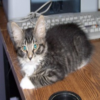

In [71]:
test_i = random.randint(0, len(test_dataset))

img, target = test_dataset[test_i]

img = img.to(device)

s = time.time()
res = model(img.unsqueeze(0))
rt = time.time() - s

print(res)
print(rt, 1/rt)
print(labels[torch.argmax(res)])
torchvision.transforms.ToPILImage()(img.cpu())

tensor([[0.9961, 0.5000]])
0.024718761444091797 40.455101371554235
Cat


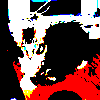

In [72]:
img, target = test_dataset[test_i]

scale, zero_point = 1.0, 0
dtype = torch.quint8
q_img = torch.quantize_per_tensor(img, scale, zero_point, dtype)

s = time.time()
res = q_model(q_img.unsqueeze(0))
rt = time.time() - s

res = res.dequantize()

print(res)
print(rt, 1/rt)
print(labels[torch.argmax(res)])
torchvision.transforms.ToPILImage()(q_img.dequantize())